# Testing Brueckner & Rosenthal: Did America’s Downtowns Get Rich?
Logan Cooper

In [9]:
import pandas as pd
import numpy as np
import gc
from tqdm.auto import tqdm
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLSResults
from typing import Tuple
import geopandas

## Data

### Data Import

#### NCDB Building Age Data (2000)

In [ ]:
ncdb_dtypes = {
    'tract_id': str,
    'workers_taking_transit': int,
    'prop_taking_transit': float,
    'built_1999_2000': int,
    'built_1995_1998': int,
    'built_1990_1994': int,
    'built_1980_1989': int,
    'built_1970_79': int,
    'built_1960_69': int,
    'built_1950_59': int,
    'built_1940_49': int,
    'built_1939_earlier': int
}
ncdb_data = pd.read_csv('./data/NCDB_2000.csv', dtype=ncdb_dtypes)
ncdb_data

In [ ]:
ncdb_data[ncdb_data['tract_id'].str.startswith('6')]

In [ ]:
ncdb_data['pub_trans_gt_10pct'] = 0
ncdb_data['pub_trans_gt_10pct'][ncdb_data['prop_taking_transit'] >= 0.1] = 1
ncdb_data

In [ ]:
ncdb_data[ncdb_data['tract_id'].str.startswith('6')]

In [ ]:
ncdb_data['pub_trans_gt_10pct'].value_counts()

In [ ]:
ncdb_data

#### Tract Level Data (2019)

In [ ]:
# import & rename cols
tract_data_2019 = pd.read_json('./data/tract_data_2019.json', dtype=False)
tract_data_2019.rename({
    'B19019_001E': 'median_income',
    'B01003_001E': 'population'
}, inplace=True, axis=1)

tract_data_2019['tract_id'] = tract_data_2019['state'] + tract_data_2019['county'] + tract_data_2019['tract']
tract_data_2019

In [ ]:
tract_data_2019['state'].value_counts().sort_index()

#### MSA-Level Income Data (2019)

In [ ]:
msa_data = pd.read_json('./data/msa_data.json')
msa_data.columns = ['name', 'median_income', 'msa_code']
msa_data['msa_code'] = msa_data['msa_code'].astype(str)
msa_data

In [ ]:
msa_data = msa_data[msa_data['name'].str.contains('Metro Area')]
msa_data

In [ ]:
# derived from an earlier notebook version where these MSA IDs turned up missing
# anything not in here is either in Puerto Rico or isn't an MSA in at least one period
changed_msa_ids = ['19380','29140','42260','31100','22460','11340','11300','14060','42060','26180','23020','39140']
changed_msa_names = ['Dayton-Kettering, OH Metro Area', 
                     'Lafayette-West Lafayette, IN Metro Area', 
                     'North Port-Sarasota-Bradenton, FL Metro Area',
                     'Los Angeles-Long Beach-Anaheim, CA Metro Area',
                     'Florence-Muscle Shoals, AL Metro Area',
                     'Greenville-Anderson, SC Metro Area',
                     'Indianapolis-Carmel-Anderson, IN Metro Area',
                     'Bloomington, IL Metro Area',
                     'Santa Maria-Santa Barbara, CA Metro Area',
                     'Urban Honolulu, HI Metro Area',
                     'Crestview-Fort Walton Beach-Destin, FL Metro Area',
                     'Prescott Valley-Prescott, AZ Metro Area']

msa_data.loc[msa_data['name'].isin(changed_msa_names), 'msa_code'] = changed_msa_ids
msa_data[msa_data['msa_code'].isin(changed_msa_ids)]


In [ ]:
msa_data.to_json('./data/msa_data.json')

#### MSA-Tract Crosswalk

In [ ]:
msa_lookup = pd.read_excel('./data/omb-cbsa-csa.xls')
msa_lookup = msa_lookup.iloc[2:].dropna(axis=1).iloc[:, [0, 2, -1]].reset_index(drop=True).dropna()
msa_lookup.columns = ['CBSA Code', 'Metropolitan/Micropolitan Statistical Area', 'FIPS Code']

for c in msa_lookup.columns:
    msa_lookup[c] = msa_lookup[c].astype(str)

msa_lookup

In [ ]:
msa_lookup['FIPS State Code'] = msa_lookup['FIPS Code'].str[:2]
msa_lookup['FIPS County Code'] = msa_lookup['FIPS Code'].str[2:]
msa_lookup.drop('FIPS Code', axis=1, inplace=True)
msa_lookup

In [ ]:
og_msas = msa_lookup[msa_lookup['Metropolitan/Micropolitan Statistical Area'] == 'Metropolitan Statistical Area']['CBSA Code'].value_counts().index
og_msas

In [ ]:
# msa_lookup = pd.read_excel('./data/msa_codes.xls', 
#                            converters={'CBSA Code': str, 
#                                        'CBSA Title': str, 
#                                        'Metropolitan/Micropolitan Statistical Area': str, 
#                                        'FIPS State Code': str,
#                                        'FIPS County Code': str}
#                            ).drop(range(1916,1920))

# msa_lookup

#### Conversion for 2000 => 2010

In [ ]:
tract_conversion = pd.read_csv('./data/us2010trf.txt')
tract_conversion

In [ ]:
tract_conversion.columns

In [ ]:
tract_conversion = tract_conversion[['GEOID00', 'GEOID10', 'AREALAND10']]
tract_conversion['GEOID00'] = tract_conversion['GEOID00'].astype(str)
tract_conversion['GEOID10'] = tract_conversion['GEOID10'].astype(str)
tract_conversion

In [ ]:
# AREALAND10 is in square meters, want it in square miles
tract_conversion['AREALAND10'] = tract_conversion['AREALAND10'] * 3.861e-7
tract_conversion = tract_conversion[tract_conversion['AREALAND10'] > 0]
tract_conversion

#### Tract-School District Crosswalk

In [ ]:
school_districts = pd.read_excel('./data/grf19_lea_tract.xlsx')
# school_districts.drop(['NAME_LEA19', 'COUNT', 'LANDAREA', 'WATERAREA'], axis=1, inplace=True)
school_districts['LEAID'] = school_districts['LEAID'].astype(str)
school_districts['TRACT'] = school_districts['TRACT'].astype(str)
school_districts

#### Wilson CBD

In [ ]:
wilson_cbd = pd.read_csv('./data/wilson_cbd.csv', index_col=False, dtype={'msa_id': str, 'wilson_cbd': str})
wilson_cbd

## Data Combination

#### Trim Tract Level Data to MSAs Only

In [ ]:
only_metros = msa_lookup[msa_lookup['Metropolitan/Micropolitan Statistical Area'] == 'Metropolitan Statistical Area']
msa_tracts = pd.merge(left=tract_data_2019, right=only_metros, left_on=['state', 'county'], right_on=['FIPS State Code', 'FIPS County Code'])
msa_tracts

In [ ]:
msa_tracts = msa_tracts[(msa_tracts['median_income'] >= 0) & (msa_tracts['population'] > 0)]
msa_tracts

In [ ]:
msa_tracts['state'].value_counts().sort_index()

In [ ]:
msa_tracts['CBSA Code'].value_counts()

In [ ]:
pr_msas = [el for el in og_msas if (el not in msa_tracts['CBSA Code'].value_counts().index)] #okay looks like these are all in PR
pr_msas

In [ ]:
msa_tracts.columns

In [ ]:
msa_tracts.drop(['Metropolitan/Micropolitan Statistical Area', 'FIPS State Code', 'FIPS County Code'], axis=1, inplace=True)
msa_tracts

In [ ]:
del only_metros
gc.collect()

#### Merge MSA-Level Data

In [ ]:
msa_tracts = pd.merge(left=msa_tracts, right=msa_data, left_on='CBSA Code', right_on='msa_code', suffixes=('_tract', '_msa'))
msa_tracts['income'] = msa_tracts['median_income_tract'] / msa_tracts['median_income_msa']
msa_tracts.drop(['CBSA Code', 'median_income_tract', 'median_income_msa'], axis=1, inplace=True)
msa_tracts

In [ ]:
[el for el in og_msas if (el not in msa_tracts['msa_code'].value_counts().index) and (el not in pr_msas)]

In [ ]:
msa_tracts['state'].value_counts().sort_index()

In [ ]:
# msa_tracts[msa_tracts['tract_id'].str.startswith('0')]['tract_id'] = msa_tracts[msa_tracts['tract_id'].str.startswith('0')]['tract_id'].str[1:]

In [ ]:
del msa_data
gc.collect()

#### Convert 2000-Tracts and Merge

In [ ]:
ages_2019 = pd.merge(left=ncdb_data, right=tract_conversion, left_on='tract_id', right_on='GEOID00')
ages_2019.drop(['tract_id', 'workers_taking_transit', 'prop_taking_transit'], axis=1, inplace=True)
ages_2019.rename({'AREALAND10': 'area', 'GEOID10': 'tract_id_2010', 'GEOID00': 'tract_id_2000'}, inplace=True, axis=1)

ages_2019

In [ ]:
non_aggregated_tract_data = ages_2019[['tract_id_2010', 'area']].drop_duplicates()
non_aggregated_tract_data

In [ ]:
summed_ages = ages_2019.groupby('tract_id_2010').sum(numeric_only=True).drop(['area'], axis=1).reset_index()
summed_ages

In [ ]:
summed_ages['pub_trans_gt_10pct'] = (summed_ages['pub_trans_gt_10pct'] >= 1).astype(int)
summed_ages

In [ ]:
summed_ages.describe()

In [ ]:
msa_tracts['tract_id'] = msa_tracts['tract_id'].str.removeprefix('0')
msa_tracts['tract_id']

In [ ]:
ages_2019 = pd.merge(left=summed_ages, right=non_aggregated_tract_data)
ages_2019

In [ ]:
ages_2019.describe()

In [ ]:
msa_tracts = pd.merge(left=msa_tracts, right=ages_2019, left_on='tract_id', right_on='tract_id_2010')
msa_tracts.drop(['tract_id'], axis=1, inplace=True)

msa_tracts = msa_tracts[(msa_tracts['population'] >= 1) & (msa_tracts['income'] > 0) & (msa_tracts['area'] > 0)] # drop weird tracts

msa_tracts['pop_density'] = msa_tracts['population'] / msa_tracts['area']
msa_tracts

In [ ]:
msa_tracts['state'].value_counts().sort_index()

In [ ]:
del ages_2019
gc.collect()

#### Add School District

In [ ]:
msa_tracts = pd.merge(left=msa_tracts, right=school_districts, left_on='tract_id_2010', right_on='TRACT')
msa_tracts.drop(['NAME_LEA19', 'TRACT', 'COUNT', 'LANDAREA', 'WATERAREA'], axis=1, inplace=True)
msa_tracts

In [ ]:
del school_districts
gc.collect()

### Add Wilson CBD

In [ ]:
wilson_cbd

In [ ]:
msa_tracts = pd.merge(left=msa_tracts, right=wilson_cbd, left_on='msa_code', right_on='msa_id')
msa_tracts.drop('msa_id', axis=1, inplace=True)
msa_tracts['wilson_cbd'] = msa_tracts['wilson_cbd'].str.removeprefix('0')
msa_tracts

In [ ]:
msa_tracts

In [ ]:
msa_tracts.to_csv('./data/msa_tracts.csv', index=False)

### Calculating Distances

#### Finding Central Business District

In [ ]:
msa_tracts = pd.read_csv('./data/msa_tracts.csv', index_col=False)
msa_tracts.rename({'msa_code_tract': 'msa_code'}, axis=1, inplace=True)
msa_tracts.drop(['area', 'population'], inplace=True, axis=1)
msa_tracts['wilson_cbd'] = msa_tracts['wilson_cbd'].astype(str)
msa_tracts

In [ ]:
msa_tracts['msa_code'].value_counts()

In [ ]:
msa_tracts['state'].value_counts().sort_index()

In [ ]:
cbd_candidates = msa_tracts[['msa_code', 'tract_id_2010', 'pop_density']]
cbds = cbd_candidates.groupby('msa_code').max()
cbds.drop('pop_density', axis=1, inplace=True)
cbds.reset_index(inplace=True)
cbds

In [ ]:
msa_tracts = pd.merge(left=msa_tracts, right=cbds, left_on='msa_code', right_on='msa_code', suffixes=('', 'cbd'))
msa_tracts.rename({'tract_id_2010cbd': 'br_cbd'}, inplace=True, axis=1)
msa_tracts['br_cbd'] = msa_tracts['br_cbd'].astype(str)
msa_tracts['tract_id_2010'] = msa_tracts['tract_id_2010'].astype(str)
msa_tracts

In [ ]:
msa_tracts['br_cbd'].str.len().value_counts()

In [ ]:
msa_tracts['tract_id_2010'].str.len().value_counts()

#### Calculating Distances

In [ ]:
def regularize_house_ages(df: pd.DataFrame) -> pd.DataFrame:
    age_cats = ['built_1999_2000',
       'built_1995_1998', 'built_1990_1994', 'built_1980_1989',
       'built_1970_1979', 'built_1960_1969', 'built_1950_1959',
       'built_1940_1949', 'built_1939_earlier']

    build_totals = df[age_cats].sum(axis=1)

    df[age_cats] = df[age_cats].div(build_totals, axis=0)
    return df
    

def get_distances_for_cbd(df: pd.DataFrame, cbd_measure: str, chunksize: int) -> pd.DataFrame:
    print(f'Starting for {cbd_measure}...')
    msa_tracts_with_dist = None
    tract_distances = pd.read_csv('./data/sf12010tractdistance50miles.csv', dtype={'county1': str,'tract1': str, 'county2': str,'tract2': str}, chunksize=chunksize)
    for chunk in tqdm(tract_distances):
        chunk['tid1'] = (chunk['county1'] + chunk['tract1']).str.removeprefix('0')
        chunk.drop(['county1', 'tract1'], axis=1, inplace=True)
        chunk['tid2'] = (chunk['county2'] + chunk['tract2']).str.removeprefix('0')
        chunk.drop(['county2', 'tract2'], axis=1, inplace=True)
        chunk.rename({'mi_to_tract': 'distance'}, axis=1, inplace=True)

        m = pd.merge(left=df, right=chunk, left_on=[cbd_measure, 'tract_id_2010'], right_on=['tid1', 'tid2'])
        if msa_tracts_with_dist is None:
            msa_tracts_with_dist = m
        else:
            msa_tracts_with_dist = pd.concat((m, msa_tracts_with_dist))

    msa_tracts_with_dist.drop(['tid1', 'tid2'], axis=1, inplace=True)
    msa_tracts_with_dist = msa_tracts_with_dist[msa_tracts_with_dist['distance'] <= 40]

    cbd_tracts = df[df['tract_id_2010'] == df[cbd_measure]]
    cbd_tracts['distance'] = 0
    msa_tracts_with_dist = pd.concat((msa_tracts_with_dist, cbd_tracts))
    msa_tracts_with_dist.drop(['state', 'county', 'tract'], axis=1, inplace=True)

    return regularize_house_ages(msa_tracts_with_dist)

In [ ]:
msa_tracts_with_dist_br = get_distances_for_cbd(msa_tracts, 'br_cbd', chunksize=200000)
msa_tracts_with_dist_br

In [ ]:
msa_tracts_with_dist_br['msa_code'].value_counts()

In [ ]:
msa_tracts_with_dist_br.to_csv('./data/msa_tracts_dist_br.csv', index=False)

In [ ]:
msa_tracts_with_dist_wilson = get_distances_for_cbd(msa_tracts, 'wilson_cbd', chunksize=200000)
msa_tracts_with_dist_wilson

In [ ]:
msa_tracts_with_dist_wilson['msa_code'].value_counts()

In [ ]:
msa_tracts_with_dist_wilson.to_csv('./data/msa_tracts_dist_wilson.csv', index=False)

## Modelling

The smallest of these models runs OLS with ~73,000 data points and 300 fixed effects. Therefore, I wasn't able to run most of them locally. Instead, I ran the models on the Duke Economics Computing Cluster and downloaded the saved models. The process for this can be seen in `reg.py`. Note that the results below omit the several thousand fixed effects.

In [10]:
import pandas as pd
from typing import Tuple

br = pd.read_csv('./data/output/msa_tracts_dist_br.csv', index_col=False, dtype={'msa_code': str, 'LEAID': str, 'pub_trans_gt_10pct': int}).dropna()
wilson = pd.read_csv('./data/output/msa_tracts_dist_wilson.csv', index_col=False, dtype={'msa_code': str, 'LEAID': str, 'pub_trans_gt_10pct': int}).dropna()

In [11]:
br

,name,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd,distance
0,"Milwaukee-Waukesha, WI Metro Area",33340,0.515123,55079001000,0.000000,0.004118,0.000000,0.010295,0.053535,0.190117,0.330817,0.225806,0.185312,0,6115.869672,5509600,55079014400,55133204502,24.226806
1,"Milwaukee-Waukesha, WI Metro Area",33340,0.433041,55079001200,0.021012,0.018147,0.021012,0.059217,0.059217,0.131805,0.480420,0.131805,0.077364,1,6523.866793,5509600,55079014400,55133204502,22.577382
2,"Milwaukee-Waukesha, WI Metro Area",33340,0.667009,55079001400,0.000000,0.000000,0.023785,0.022751,0.292658,0.210962,0.365047,0.037229,0.047570,0,6183.949443,5509600,55079014400,55133204502,21.048195
3,"Milwaukee-Waukesha, WI Metro Area",33340,0.601484,55079001900,0.000000,0.003693,0.004431,0.045790,0.101920,0.148449,0.467504,0.112999,0.115214,1,8415.702691,5509600,55079014400,55133204502,22.717102
4,"Milwaukee-Waukesha, WI Metro Area",33340,0.456699,55079002400,0.000000,0.000000,0.000000,0.003036,0.043522,0.153846,0.238866,0.281377,0.279352,1,5544.246309,5509600,55079014400,55133204502,24.347973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56028,"Wausau-Weston, WI Metro Area",48140,1.039428,55073002300,0.021973,0.082504,0.065506,0.089138,0.139303,0.058458,0.063018,0.065506,0.414594,0,29.006610,5515900,55073000100,55073002300,0.000000
56029,"Sheboygan, WI Metro Area",43100,0.760709,55117011400,0.006944,0.023920,0.010031,0.005401,0.025463,0.080247,0.065586,0.091049,0.691358,0,4580.854245,5513650,55117011400,55117011400,0.000000
56030,"Casper, WY Metro Area",16220,1.330880,56025001800,0.036853,0.098984,0.042523,0.158753,0.329081,0.118828,0.071108,0.054099,0.089771,0,1.124130,5604510,56025000200,56025001800,0.000000
56031,"Cheyenne, WY Metro Area",16940,1.303751,56021002000,0.054812,0.095162,0.039814,0.162650,0.231744,0.066238,0.067309,0.078914,0.203357,0,9.350342,5601980,56021000700,56021002000,0.000000


In [12]:
wilson

,name,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd,distance
0,"Oshkosh-Neenah, WI Metro Area",36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5510590,55139000500,55139003702,16.531156
1,"Oshkosh-Neenah, WI Metro Area",36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5516500,55139000500,55139003702,16.531156
2,"Oshkosh-Neenah, WI Metro Area",36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5516830,55139000500,55139003702,16.531156
3,"Oshkosh-Neenah, WI Metro Area",36780,1.567361,55139002300,0.031792,0.132948,0.128613,0.105130,0.223627,0.138728,0.053829,0.043714,0.141618,0,90.024009,5510320,55139000500,55139003702,10.031904
4,"Oshkosh-Neenah, WI Metro Area",36780,1.567361,55139002300,0.031792,0.132948,0.128613,0.105130,0.223627,0.138728,0.053829,0.043714,0.141618,0,90.024009,5510590,55139000500,55139003702,10.031904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77062,"Janesville-Beloit, WI Metro Area",27500,0.322540,55105000100,0.000000,0.066574,0.151179,0.058252,0.205270,0.020804,0.058252,0.044383,0.395284,0,4166.809379,5507020,55105000100,55105003300,0.000000
77063,"Wausau-Weston, WI Metro Area",48140,0.510658,55073000100,0.008169,0.013615,0.002723,0.006127,0.027229,0.051055,0.083730,0.070796,0.736555,0,4203.115079,5515900,55073000100,55073002300,0.000000
77064,"Sheboygan, WI Metro Area",43100,0.760709,55117011400,0.006944,0.023920,0.010031,0.005401,0.025463,0.080247,0.065586,0.091049,0.691358,0,4580.854245,5513650,55117011400,55117011400,0.000000
77065,"Casper, WY Metro Area",16220,0.541786,56025000200,0.022963,0.032805,0.022143,0.123838,0.297704,0.089666,0.088573,0.084746,0.237562,0,1761.722367,5604510,56025000200,56025001800,0.000000


In [13]:
br.describe()

,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,wilson_cbd,br_cbd,distance
count,56028.000000,5.602800e+04,56028.000000,56028.000000,56028.000000,56028.000000,56028.000000,56028.000000,56028.000000,56028.000000,56028.000000,56028.000000,56028.000000,5.602800e+04,5.602800e+04,56028.000000
mean,1.072154,2.688078e+10,0.027722,0.079585,0.076293,0.155977,0.186427,0.139938,0.131291,0.070423,0.132345,0.095952,3798.873505,2.684269e+10,2.875534e+10,20.285244
std,0.434979,1.665964e+10,0.046553,0.092313,0.072698,0.118131,0.112437,0.097667,0.115302,0.071879,0.161595,0.294528,5668.256597,1.661653e+10,1.745898e+10,10.552950
min,0.041103,1.001020e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087925,1.015001e+09,1.015003e+09,0.000000
25%,0.774374,9.009125e+09,0.002593,0.013840,0.021543,0.068490,0.110140,0.076776,0.049408,0.017615,0.016667,0.000000,402.383103,9.003502e+09,9.013890e+09,11.861683
50%,1.022835,2.616143e+10,0.013258,0.050589,0.058506,0.134949,0.175472,0.120495,0.101912,0.049756,0.065866,0.000000,2152.011271,2.616352e+10,2.951013e+10,20.045488
75%,1.300292,4.105100e+10,0.034661,0.112546,0.109823,0.214107,0.241989,0.181274,0.181976,0.099130,0.190222,0.000000,4912.051384,4.105101e+10,4.400905e+10,28.857955
max,4.463666,5.602500e+10,1.000000,1.000000,0.777904,1.000000,0.919065,1.000000,1.000000,1.000000,0.962963,1.000000,155286.881355,5.602500e+10,5.602500e+10,39.999000


In [14]:
wilson.describe()

,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,wilson_cbd,br_cbd,distance
count,77055.000000,7.705500e+04,77055.000000,77055.000000,77055.000000,77055.000000,77055.000000,77055.000000,77055.000000,77055.000000,77055.000000,77055.000000,77055.000000,7.705500e+04,7.705500e+04,77055.000000
mean,1.078050,2.651302e+10,0.028259,0.078583,0.075081,0.155153,0.181889,0.139560,0.132543,0.072145,0.136786,0.157109,5548.580609,2.644008e+10,3.018941e+10,13.729268
std,0.447568,1.628791e+10,0.050693,0.095617,0.075025,0.123485,0.116826,0.099406,0.117911,0.074394,0.167988,0.363905,11771.115509,1.631367e+10,1.796708e+10,9.651490
min,0.041103,1.001020e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.197218,1.015001e+09,1.015003e+09,0.000000
25%,0.769346,1.000301e+10,0.001731,0.012129,0.018640,0.061478,0.098287,0.073921,0.046906,0.016315,0.014925,0.000000,568.803237,1.100101e+10,1.207109e+10,5.840965
50%,1.023612,2.612516e+10,0.011927,0.046214,0.055464,0.130814,0.169130,0.120103,0.102867,0.050152,0.064652,0.000000,2576.669600,2.616352e+10,3.504594e+10,11.557904
75%,1.310210,4.001730e+10,0.034147,0.110784,0.108352,0.215999,0.240280,0.183141,0.185628,0.103527,0.201538,0.000000,5769.737304,4.010910e+10,4.715306e+10,20.005752
max,4.463666,5.602500e+10,1.000000,1.000000,0.777904,1.000000,0.919065,1.000000,1.000000,1.000000,0.962963,1.000000,690022.379383,5.602500e+10,5.602500e+10,39.998436


In [15]:
br.describe()[['income', 'distance']].to_latex('./assets/tables/br_desc.tex')
wilson.describe()[['income', 'distance']].to_latex('./assets/tables/wilson_desc.tex')

/tmp/ipykernel_1313/1470021974.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  br.describe()[['income', 'distance']].to_latex('./assets/tables/br_desc.tex')
/tmp/ipykernel_1313/1470021974.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  wilson.describe()[['income', 'distance']].to_latex('./assets/tables/wilson_desc.tex')


In [16]:
import re
fixed_effects = re.compile(r'C\([A-Za-z_]+\).+\n')

def print_model_output(model_type: str, model_num: int, model: str) -> str:
    with open(f'./models/model-{model_type}-{model_num}-summary.txt', 'r') as f:
        print(fixed_effects.sub('', f.read()))

## Graphing

<Axes: title={'center': 'Wilson'}, xlabel='Wilson-Distance', ylabel='Tract Income'>

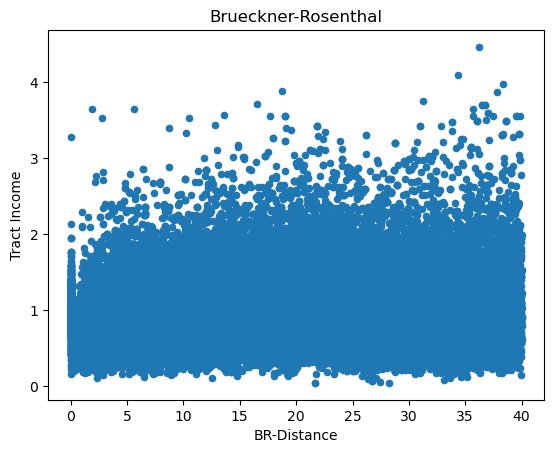

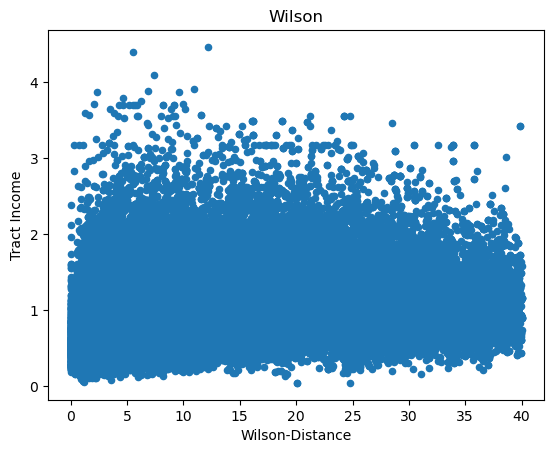

In [17]:
from matplotlib import pyplot as plt

br.plot(kind='scatter', x='distance', y='income', xlabel='BR-Distance', ylabel='Tract Income', title='Brueckner-Rosenthal')
wilson.plot(kind='scatter', x='distance', y='income', xlabel='Wilson-Distance', ylabel='Tract Income', title='Wilson')

Text(0.5, 1.0, 'Brueckner-Rosenthal')

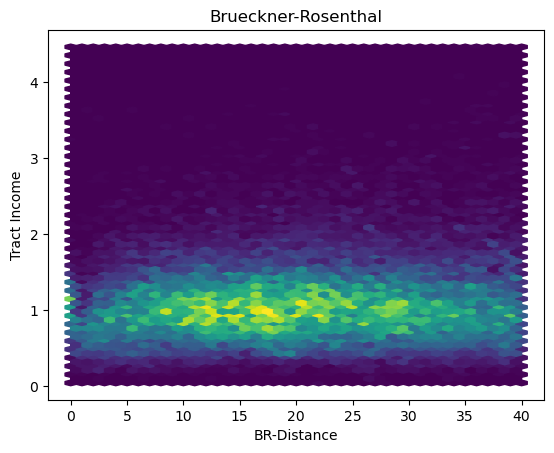

In [18]:
plt.hexbin(x=br['distance'], y=br['income'], gridsize=(40, 40))
plt.xlabel('BR-Distance')
plt.ylabel('Tract Income')
plt.title('Brueckner-Rosenthal')

Text(0.5, 1.0, 'Wilson')

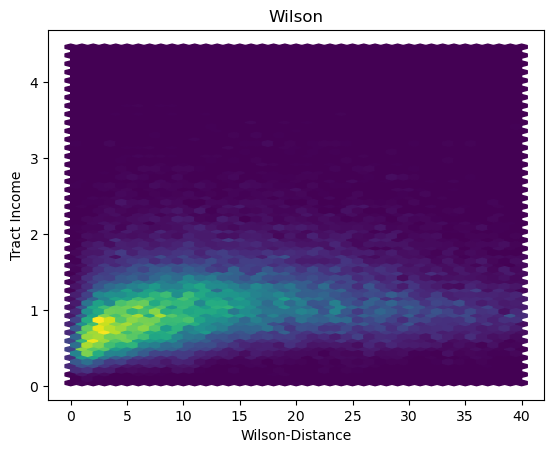

In [19]:
plt.hexbin(x=wilson['distance'], y=wilson['income'], gridsize=(40, 40))
plt.xlabel('Wilson-Distance')
plt.ylabel('Tract Income')
plt.title('Wilson')

In [20]:
def add_tract_counts(df: pd.DataFrame) -> pd.DataFrame:
    tract_counts =df.groupby('msa_code').count()['income']
    tract_counts = tract_counts.reset_index().rename({'income': 'tract_counts'}, axis=1)
    return pd.merge(right=df, left=tract_counts, left_on='msa_code', right_on='msa_code')

def discretize_distances(df: pd.DataFrame) -> pd.DataFrame:
    df['dist_bin'] = df['distance'].round()
    return df

def split_df_by_tract_counts(df: pd.DataFrame) -> Tuple[pd.DataFrame]:
    under_100 = df[df['tract_counts'] < 100]
    btw_100_500 = df[(df['tract_counts'] >= 100) & (df['tract_counts'] < 500)]
    btw_500_1000 = df[(df['tract_counts'] >= 500) & (df['tract_counts'] < 1000)]
    larger_1000 = df[df['tract_counts'] >= 1000]

    return (under_100, btw_100_500, btw_500_1000, larger_1000)

def plot_relative_income(df: pd.DataFrame, title: str, dist: str) -> None:
    df_dist_inc = df.groupby('dist_bin').mean()['income']
    plt.plot((df_dist_inc - df_dist_inc[0]) / df_dist_inc[0])
    plt.xlabel(f'{dist}-Distance from CBD (mi)')
    plt.ylabel('Median Income Compared to Mile Zero')
    plt.title(title)

def plot_housing_dist(df: pd.DataFrame) -> None:
    df.groupby('dist_bin').mean()[
    ['built_1999_2000', 
        'built_1995_1998', 
        'built_1990_1994', 
        'built_1980_1989', 
        'built_1970_1979', 
        'built_1960_1969', 
        'built_1950_1959', 
        'built_1940_1949', 
        'built_1939_earlier']
    ].plot(xlabel='Distance from CBD (mi)', ylabel='Mean Share of Housing Age')

def process_dataframe(df: pd.DataFrame) -> Tuple[pd.DataFrame]:
    return split_df_by_tract_counts(discretize_distances(add_tract_counts(df)))

In [21]:
under_100_br, btw_100_500_br, btw_500_1000_br, larger_1000_br = process_dataframe(br)
under_100_wilson, btw_100_500_wilson, btw_500_1000_wilson, larger_1000_wilson = process_dataframe(wilson)

/tmp/ipykernel_1313/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


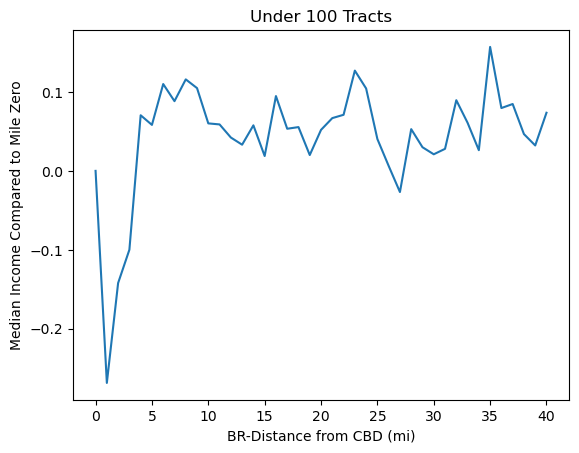

In [22]:
plot_relative_income(under_100_br, 'Under 100 Tracts', 'BR')

/tmp/ipykernel_1313/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


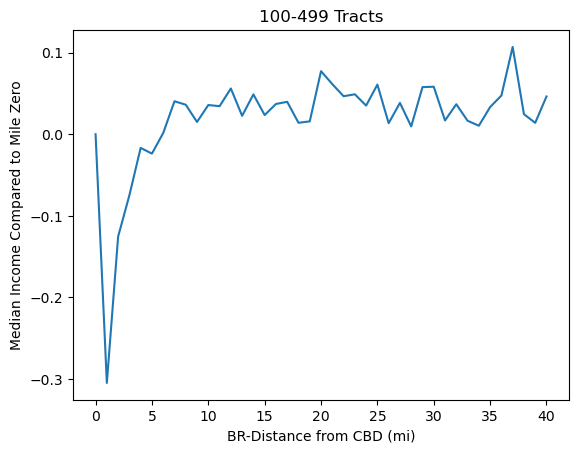

In [23]:
plot_relative_income(btw_100_500_br, '100-499 Tracts', 'BR')

/tmp/ipykernel_1313/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


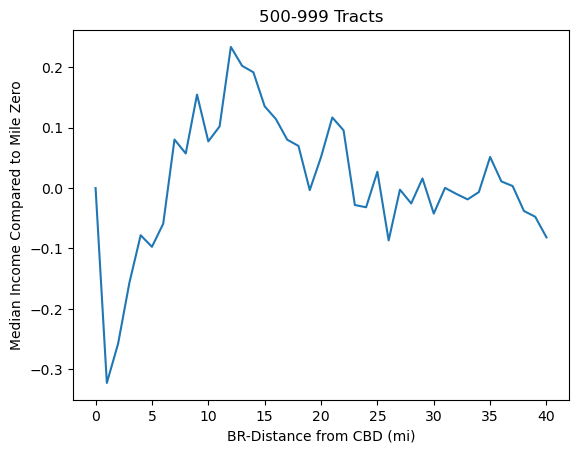

In [24]:
plot_relative_income(btw_500_1000_br, '500-999 Tracts', 'BR')

/tmp/ipykernel_1313/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


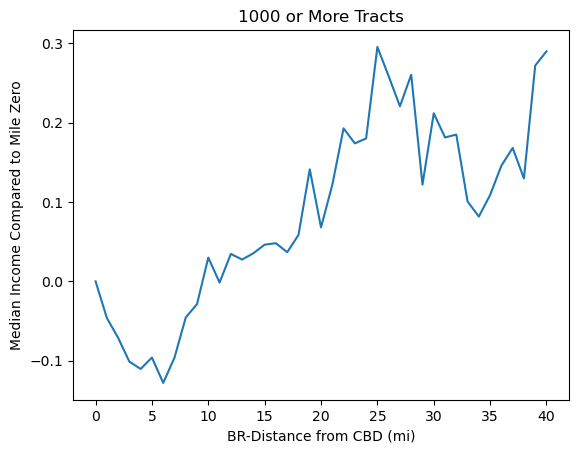

In [25]:
plot_relative_income(larger_1000_br, '1000 or More Tracts', 'BR')

/tmp/ipykernel_1313/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


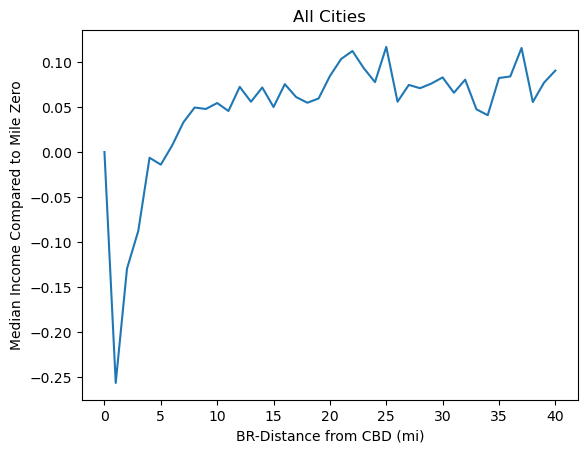

In [26]:
plot_relative_income(discretize_distances(br), 'All Cities', 'BR')

/tmp/ipykernel_1313/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


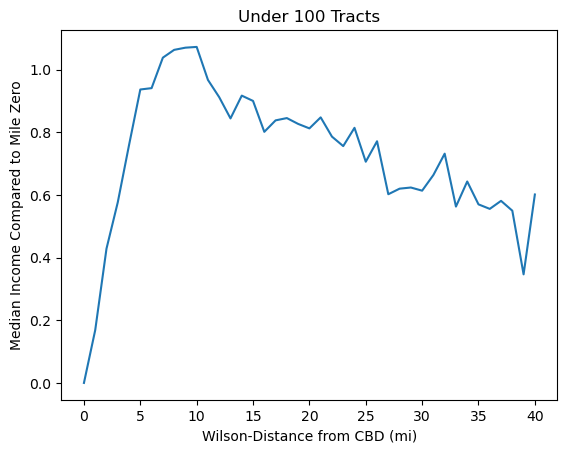

In [27]:
plot_relative_income(under_100_wilson, 'Under 100 Tracts', 'Wilson')

/tmp/ipykernel_1313/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


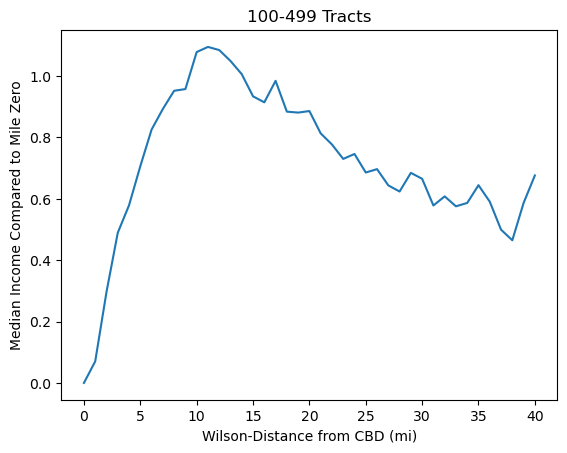

In [28]:
plot_relative_income(btw_100_500_wilson, '100-499 Tracts', 'Wilson')

/tmp/ipykernel_1313/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


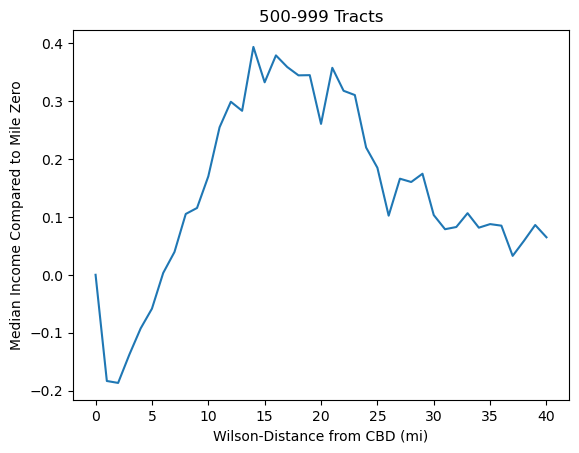

In [29]:
plot_relative_income(btw_500_1000_wilson, '500-999 Tracts', 'Wilson')

/tmp/ipykernel_1313/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


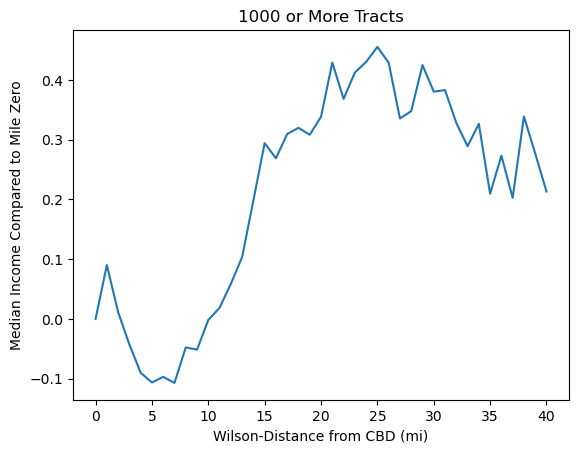

In [30]:
plot_relative_income(larger_1000_wilson, '1000 or More Tracts', 'Wilson')

/tmp/ipykernel_1313/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


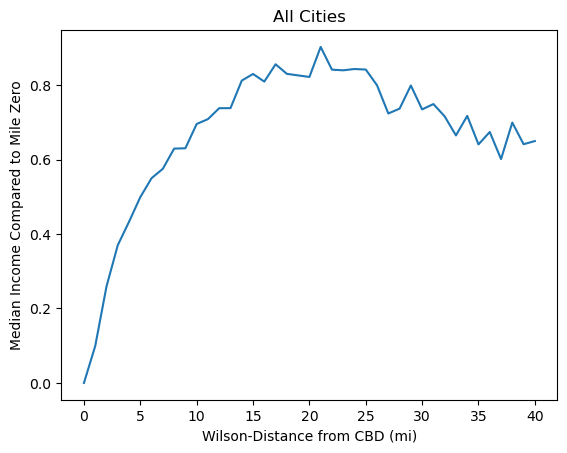

In [31]:
plot_relative_income(discretize_distances(wilson), 'All Cities', 'Wilson')

## Mapping

In [32]:
def geofy_data(df: pd.DataFrame) -> geopandas.GeoDataFrame:
    ca_geo = geopandas.read_file('./data/CA_shapefile/tl_2010_06_tract00.shp')
    ca_geo = ca_geo[['CTIDFP00', 'geometry']]

    ca_geo['CTIDFP00'] = ca_geo['CTIDFP00'].astype(str).str.removeprefix('0')
    df['tract_id_2010'] = df['tract_id_2010'].astype(str)

    ca_geo = pd.merge(left=ca_geo, right=df, left_on='CTIDFP00', right_on='tract_id_2010')
    return ca_geo.dropna()